In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery as bq

%matplotlib inline

# All sig-DMDs

## Extract methylation data

In [2]:
probe = pd.read_table("./metadata/sig-DMD.union.includeERR.hm450probes", sep="\t", header=None)
probe.columns = ['chrom', 'start', 'end', 'probe_id', 
                 'UCSC.RefGene_Group', 'UCSC.RefGene_Accession', 'UCSC.RefGene_Name', 
                 'sig-DMD', 'DMV', 'pairs', 'no_pairs']

print(probe.shape)
probe.head()

(25329, 11)


,chrom,start,end,probe_id,UCSC.RefGene_Group,UCSC.RefGene_Accession,UCSC.RefGene_Name,sig-DMD,DMV,pairs,no_pairs
0,chr1,864878,864880,cg02896266,Body,NM_152486,SAMD11,sig-DMD_1,DMV_4,"nontrip_trip,normal_trip",2
1,chr1,931326,931328,cg03648020,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3
2,chr1,933305,933307,cg01729262,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3
3,chr1,933387,933389,cg15882305,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3
4,chr1,933684,933686,cg15713103,NaN,NaN,NaN,sig-DMD_2,DMV_6,"nontrip_trip,normal_nontrip,normal_trip",3


In [3]:
sample = pd.read_table("./metadata/subtype_metadata.tsv", sep="\t")

print(sample.shape)
sample.head()

(1282, 5)


,case_barcode,sample_barcode,sample_type,sample_type_name,subtype
0,TCGA-A2-A04P,TCGA-A2-A04P-01A,1,Primary solid Tumor,Basal
1,TCGA-AR-A0TP,TCGA-AR-A0TP-01A,1,Primary solid Tumor,Basal
2,TCGA-GM-A2DF,TCGA-GM-A2DF-01A,1,Primary solid Tumor,Basal
3,TCGA-BH-A0C0,TCGA-BH-A0C0-01A,1,Primary solid Tumor,LumB
4,TCGA-D8-A141,TCGA-D8-A141-01A,1,Primary solid Tumor,LumA


In [4]:
# fill NaN value in subtype into Unknown
sample.fillna(value={'subtype': 'Unknown'}, inplace=True)
sample.subtype.value_counts()

LumA       581
LumB       219
Basal      193
Normal     143
Her2        82
Unknown     64
Name: subtype, dtype: int64

-----------------------

In [5]:
sample_barcodes = ", ".join("'%s'" % w for w in sample.sample_barcode)
probe_ids = ", ".join("'%s'" % w for w in probe.probe_id)

In [6]:
client = bq.Client()
methylation = 'isb-cgc.TCGA_hg19_data_v0.DNA_Methylation'

# some aliquots are duplicated => we take the average of those duplicates 
query="""\
SELECT 
    case_barcode, sample_barcode, aliquot_barcode, probe_id,
    AVG(beta_value) AS avg_beta_value
FROM
    `{}`
WHERE
    platform = "HumanMethylation450" AND
    sample_barcode IN ({}) AND probe_id IN ({})
GROUP BY
    case_barcode, sample_barcode, aliquot_barcode, probe_id
""".format(methylation, sample_barcodes, probe_ids)

subtype_meth = client.query(query).to_dataframe()

print(subtype_meth.shape)

subtype_meth.head()

(20313452, 5)


,case_barcode,sample_barcode,aliquot_barcode,probe_id,avg_beta_value
0,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg17337672,0.99
1,TCGA-BH-A0HA,TCGA-BH-A0HA-01A,TCGA-BH-A0HA-01A-11D-A12R-05,cg13599131,0.97
2,TCGA-A7-A13F,TCGA-A7-A13F-11A,TCGA-A7-A13F-11A-42D-A12R-05,cg27386326,0.95
3,TCGA-A7-A13G,TCGA-A7-A13G-11A,TCGA-A7-A13G-11A-51D-A13T-05,cg14359798,0.95
4,TCGA-EW-A423,TCGA-EW-A423-01A,TCGA-EW-A423-01A-11D-A244-05,cg21919790,0.99


In [7]:
subtype_meth.to_csv("./datasets/subtype_meth.HM450.tsv", sep="\t", index=False)

-------------------------

In [9]:
subtype_meth = pd.read_table("./datasets/subtype_meth.HM450.tsv", sep="\t")
print(subtype_meth.shape)
subtype_meth.head()

(20313452, 5)


,case_barcode,sample_barcode,aliquot_barcode,probe_id,avg_beta_value
0,TCGA-E2-A106,TCGA-E2-A106-01A,TCGA-E2-A106-01A-11D-A10N-05,cg12967902,0.98
1,TCGA-BH-A0DP,TCGA-BH-A0DP-11A,TCGA-BH-A0DP-11A-12D-A10Q-05,cg05109966,0.95
2,TCGA-AC-A7VC,TCGA-AC-A7VC-01A,TCGA-AC-A7VC-01A-11D-A357-05,cg27656658,0.97
3,TCGA-E2-A576,TCGA-E2-A576-01A,TCGA-E2-A576-01A-11D-A31V-05,cg24197303,0.96
4,TCGA-A2-A0T6,TCGA-A2-A0T6-01A,TCGA-A2-A0T6-01A-11D-A10P-05,cg06430029,0.95


In [8]:
subtype_meth_bigtable = pd.merge(left=subtype_meth, right=sample, how='inner', on=["sample_barcode", "case_barcode"])

print(subtype_meth_bigtable.shape)
subtype_meth_bigtable.head()

(20313452, 8)


,case_barcode,sample_barcode,aliquot_barcode,probe_id,avg_beta_value,sample_type,sample_type_name,subtype
0,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg17337672,0.99,1,Primary solid Tumor,LumA
1,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg11687966,0.96,1,Primary solid Tumor,LumA
2,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg00891184,0.95,1,Primary solid Tumor,LumA
3,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg09265619,0.98,1,Primary solid Tumor,LumA
4,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg20293609,0.99,1,Primary solid Tumor,LumA


In [9]:
print("Sample types")
print(subtype_meth_bigtable.drop_duplicates(subset="sample_barcode").sample_type_name.value_counts())
print("\n")

print("BRCA subtypes")
print(subtype_meth_bigtable.drop_duplicates(subset="case_barcode").subtype.value_counts())

Sample types
Primary solid Tumor    789
Solid Tissue Normal     98
Metastatic               5
Name: sample_type_name, dtype: int64


BRCA subtypes
LumA       396
LumB       134
Basal      128
Normal      76
Her2        43
Unknown     12
Name: subtype, dtype: int64


In [10]:
subtype_meth_bigtable.to_csv("./datasets/subtype_meth_bigtable.HM450.tsv", sep="\t", index=False)

## Use extracted methylation data --> big matrix

In [8]:
subtype_meth_bigtable = pd.read_table("./datasets/subtype_meth_bigtable.HM450.tsv", sep="\t")

print(subtype_meth_bigtable.shape)
subtype_meth_bigtable.head()

(20313452, 8)


,case_barcode,sample_barcode,aliquot_barcode,probe_id,avg_beta_value,sample_type,sample_type_name,subtype
0,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg17337672,0.99,1,Primary solid Tumor,LumA
1,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg11687966,0.96,1,Primary solid Tumor,LumA
2,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg00891184,0.95,1,Primary solid Tumor,LumA
3,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg09265619,0.98,1,Primary solid Tumor,LumA
4,TCGA-AO-A0JC,TCGA-AO-A0JC-01A,TCGA-AO-A0JC-01A-11D-A10P-05,cg20293609,0.99,1,Primary solid Tumor,LumA


In [4]:
matrix = subtype_meth_bigtable.pivot(index='probe_id', columns='aliquot_barcode', values='avg_beta_value')

print(matrix.shape)
matrix.head()

(22742, 894)


aliquot_barcode,TCGA-3C-AAAU-01A-11D-A41Q-05,TCGA-3C-AALI-01A-11D-A41Q-05,TCGA-3C-AALJ-01A-31D-A41Q-05,TCGA-3C-AALK-01A-11D-A41Q-05,TCGA-4H-AAAK-01A-12D-A41Q-05,TCGA-5L-AAT0-01A-12D-A41Q-05,TCGA-5L-AAT1-01A-12D-A41Q-05,TCGA-5T-A9QA-01A-11D-A41Q-05,TCGA-A1-A0SB-01A-11D-A145-05,TCGA-A1-A0SE-01A-11D-A10P-05,...,TCGA-UL-AAZ6-01A-11D-A41Q-05,TCGA-UU-A93S-01A-21D-A41Q-05,TCGA-V7-A7HQ-01A-11D-A33F-05,TCGA-W8-A86G-01A-21D-A36K-05,TCGA-WT-AB41-01A-11D-A41Q-05,TCGA-WT-AB44-01A-11D-A41Q-05,TCGA-XX-A899-01A-11D-A36K-05,TCGA-XX-A89A-01A-11D-A36K-05,TCGA-Z7-A8R5-01A-42D-A41Q-05,TCGA-Z7-A8R6-01A-11D-A41Q-05
probe_id,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.10,0.14,0.15,0.20,0.21,0.24,0.25,0.10,0.06,0.16,...,0.23,0.13,0.12,0.18,0.25,0.18,0.28,0.25,0.23,0.08
cg00000321,0.39,0.30,0.61,0.58,0.47,0.59,0.40,0.78,0.26,0.30,...,0.61,0.62,0.50,0.47,0.65,0.66,0.54,0.28,0.50,0.13
cg00000363,0.22,0.43,0.77,0.68,0.21,0.25,0.47,0.84,0.06,0.41,...,0.68,0.45,0.13,0.31,0.19,0.31,0.25,0.21,0.39,0.11
cg00001747,0.03,0.06,0.06,0.55,0.62,0.38,0.53,0.84,0.01,0.06,...,0.79,0.39,0.17,0.04,0.55,0.70,0.52,0.37,0.08,0.34
cg00002426,0.31,0.87,0.45,0.39,0.35,0.46,0.56,0.85,0.12,0.36,...,0.41,0.43,0.31,0.34,0.53,0.27,0.54,0.48,0.51,0.22


## Correlation among all samples, all sig-DMDs

In [5]:
corr = matrix.corr()

In [7]:
corr.to_csv("./datasets/subtype_meth_corr.allsigDMD.HM450.tsv", sep="\t")
del corr

--------------------------------------

In [3]:
corr = pd.read_table("./datasets/subtype_meth_corr.allsigDMD.HM450.tsv", sep="\t", index_col='aliquot_barcode')
corr

,TCGA-3C-AAAU-01A-11D-A41Q-05,TCGA-3C-AALI-01A-11D-A41Q-05,TCGA-3C-AALJ-01A-31D-A41Q-05,TCGA-3C-AALK-01A-11D-A41Q-05,TCGA-4H-AAAK-01A-12D-A41Q-05,TCGA-5L-AAT0-01A-12D-A41Q-05,TCGA-5L-AAT1-01A-12D-A41Q-05,TCGA-5T-A9QA-01A-11D-A41Q-05,TCGA-A1-A0SB-01A-11D-A145-05,TCGA-A1-A0SE-01A-11D-A10P-05,...,TCGA-UL-AAZ6-01A-11D-A41Q-05,TCGA-UU-A93S-01A-21D-A41Q-05,TCGA-V7-A7HQ-01A-11D-A33F-05,TCGA-W8-A86G-01A-21D-A36K-05,TCGA-WT-AB41-01A-11D-A41Q-05,TCGA-WT-AB44-01A-11D-A41Q-05,TCGA-XX-A899-01A-11D-A36K-05,TCGA-XX-A89A-01A-11D-A36K-05,TCGA-Z7-A8R5-01A-42D-A41Q-05,TCGA-Z7-A8R6-01A-11D-A41Q-05
aliquot_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01A-11D-A41Q-05,1.000000,0.713910,0.734213,0.732222,0.754234,0.758741,0.734037,0.602536,0.565416,0.781523,...,0.685622,0.629560,0.770504,0.757485,0.695147,0.700924,0.719371,0.729499,0.736685,0.732241
TCGA-3C-AALI-01A-11D-A41Q-05,0.713910,1.000000,0.776073,0.748062,0.716982,0.730285,0.752015,0.624025,0.543782,0.749975,...,0.728024,0.690138,0.724836,0.717610,0.699101,0.667122,0.719496,0.746099,0.728448,0.682262
TCGA-3C-AALJ-01A-31D-A41Q-05,0.734213,0.776073,1.000000,0.826138,0.750854,0.761400,0.797207,0.746347,0.521093,0.758394,...,0.780077,0.700726,0.740297,0.728592,0.757802,0.723125,0.762600,0.729313,0.750337,0.693430
TCGA-3C-AALK-01A-11D-A41Q-05,0.732222,0.748062,0.826138,1.000000,0.848914,0.860139,0.888383,0.800670,0.621249,0.841758,...,0.717335,0.717455,0.814771,0.848342,0.851420,0.832207,0.873215,0.787240,0.869361,0.760551
TCGA-4H-AAAK-01A-12D-A41Q-05,0.754234,0.716982,0.750854,0.848914,1.000000,0.868780,0.856004,0.704421,0.673680,0.857708,...,0.650815,0.666839,0.856138,0.880660,0.813093,0.821075,0.868429,0.814416,0.870395,0.801015
TCGA-5L-AAT0-01A-12D-A41Q-05,0.758741,0.730285,0.761400,0.860139,0.868780,1.000000,0.880464,0.688665,0.689266,0.876006,...,0.635784,0.673816,0.859271,0.891111,0.839607,0.816339,0.889143,0.840395,0.896964,0.795798
TCGA-5L-AAT1-01A-12D-A41Q-05,0.734037,0.752015,0.797207,0.888383,0.856004,0.880464,1.000000,0.746460,0.636640,0.842632,...,0.664734,0.719407,0.820639,0.850490,0.871928,0.820007,0.912710,0.837639,0.895448,0.759338
TCGA-5T-A9QA-01A-11D-A41Q-05,0.602536,0.624025,0.746347,0.800670,0.704421,0.688665,0.746460,1.000000,0.477880,0.672652,...,0.673227,0.614551,0.653410,0.681863,0.762236,0.732300,0.730979,0.630318,0.701672,0.610005
TCGA-A1-A0SB-01A-11D-A145-05,0.565416,0.543782,0.521093,0.621249,0.673680,0.689266,0.636640,0.477880,1.000000,0.700456,...,0.406684,0.469546,0.674200,0.755054,0.621194,0.606283,0.680774,0.672949,0.758611,0.586076


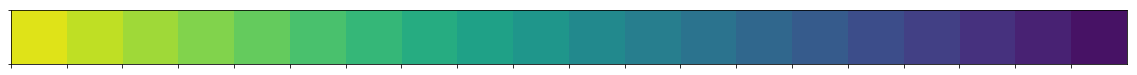

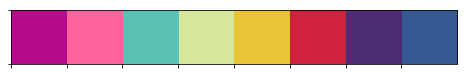

In [6]:
sns.palplot(sns.color_palette("viridis_r", n_colors=20))
sns.palplot(sns.color_palette(["#b7098b","#ff639c", "#5bc1b5", "#d6e79a", "#eac435", "#d0213e", "#4c2c72", "#345995"]))

In [13]:
print(df['sample_type_name'].unique())
print(df['subtype'].unique())

['Primary solid Tumor' 'Solid Tissue Normal' 'Metastatic']
['LumA' 'Normal' 'Her2' 'LumB' 'Basal' 'Unknown']


In [14]:
color_matrix = pd.DataFrame()
df = subtype_meth_bigtable.drop_duplicates(subset="aliquot_barcode")

c = dict(zip(df['sample_type_name'].unique(), ["#ff639c", "#5bc1b5", "#b7098b"]))
color_matrix['Sample type'] = df['sample_type_name'].map(c)

c = dict(zip(df['subtype'].unique(), ["#d6e79a", "#345995", "#4c2c72", "#eac435", "#d0213e", "#ffffff"]))
color_matrix['Subtype'] = df['subtype'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Sample type,Subtype
aliquot_barcode,,
TCGA-AO-A0JC-01A-11D-A10P-05,#ff639c,#d6e79a
TCGA-BH-A0HA-01A-11D-A12R-05,#ff639c,#d6e79a
TCGA-A7-A13F-11A-42D-A12R-05,#5bc1b5,#345995
TCGA-A7-A13G-11A-51D-A13T-05,#5bc1b5,#d6e79a
TCGA-EW-A423-01A-11D-A244-05,#ff639c,#d6e79a


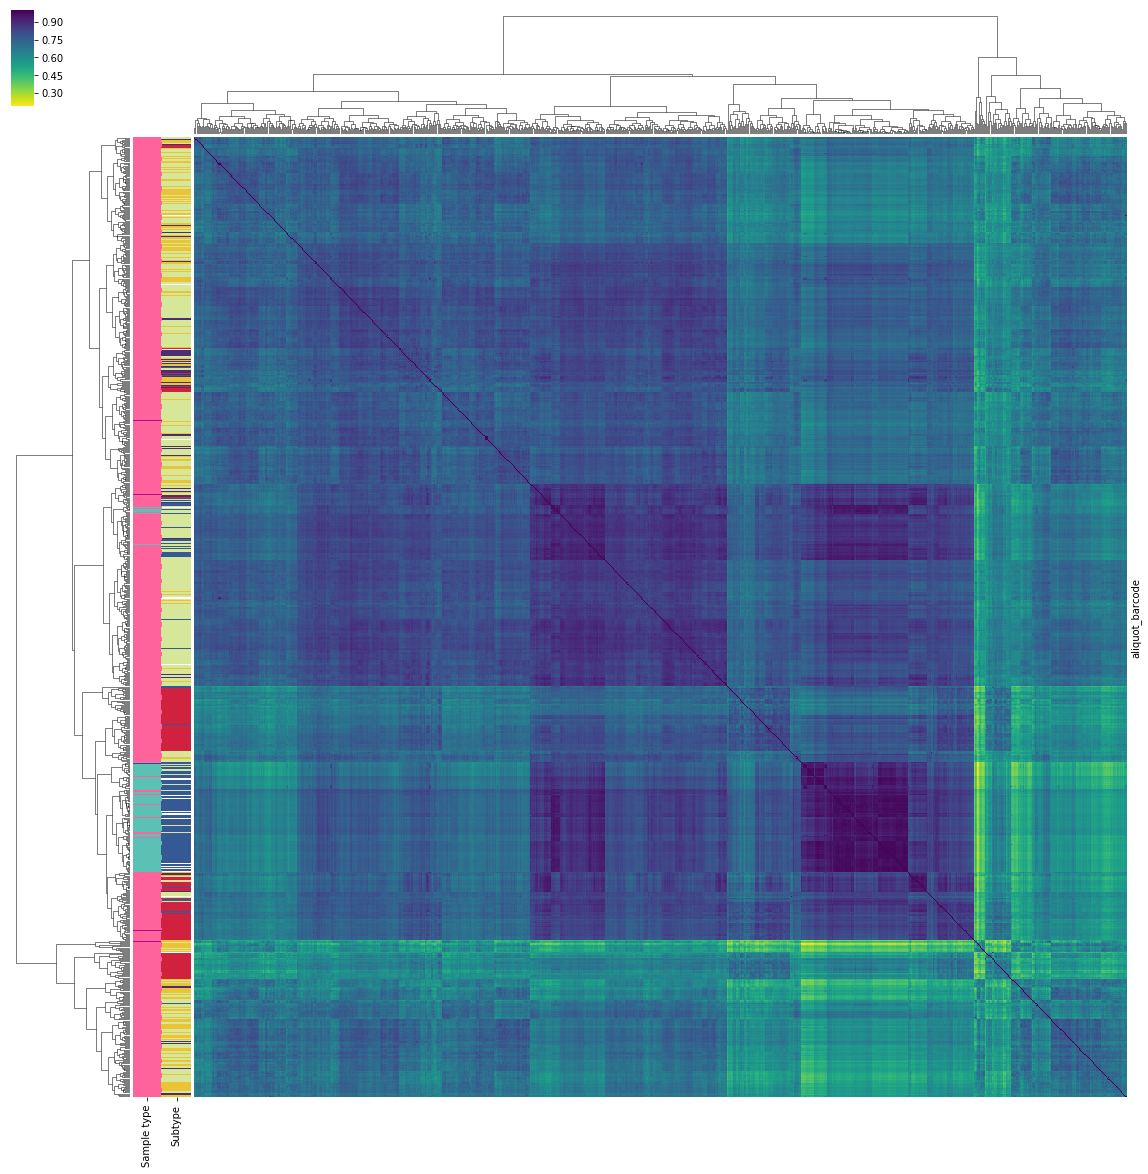

In [15]:
sns.clustermap(data=corr, method='complete', 
               row_colors=color_matrix,
               cmap="viridis_r", vmax=1, figsize=(20,20), 
               xticklabels=False, yticklabels=False)

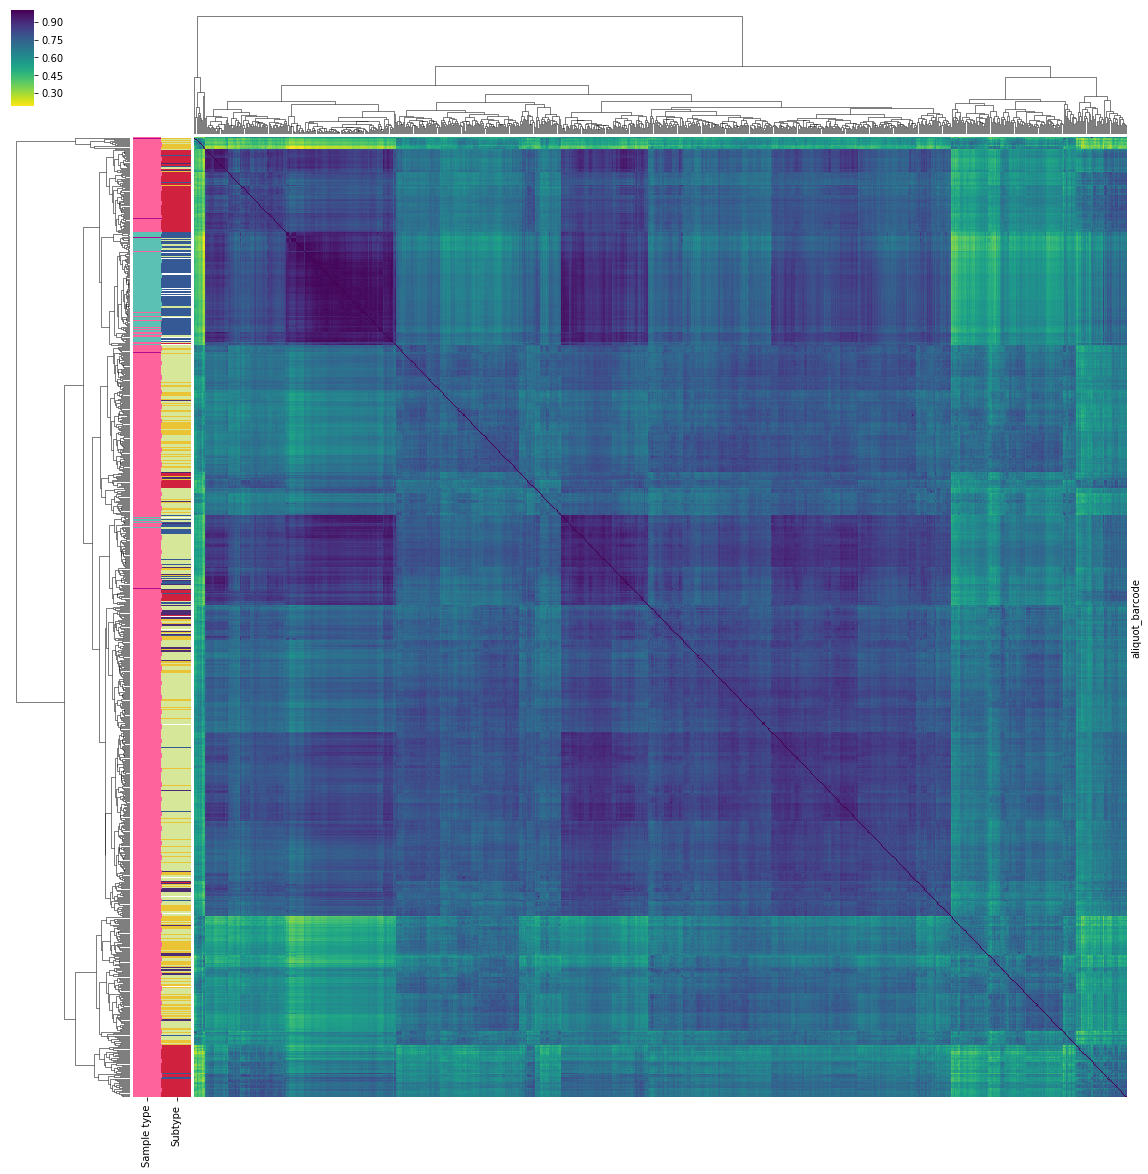

In [16]:
sns.clustermap(data=corr, method='average', 
               row_colors=color_matrix,
               cmap="viridis_r", vmax=1, figsize=(20,20), 
               xticklabels=False, yticklabels=False)

# Exclude normal

In [35]:
hormone_meth_bigtable['sample_type'].value_counts()

1     599744
11     67348
Name: sample_type, dtype: int64

In [36]:
exclude_normal = hormone_meth_bigtable.loc[hormone_meth_bigtable['sample_type'] == 1]
matrix = exclude_normal.pivot(index='probe_id', columns='aliquot_barcode', values='beta_value')

print(matrix.shape)
matrix.head()

(1605, 374)


aliquot_barcode,TCGA-5L-AAT0-01A-12D-A41Q-05,TCGA-5L-AAT1-01A-12D-A41Q-05,TCGA-5T-A9QA-01A-11D-A41Q-05,TCGA-A1-A0SF-01A-11D-A145-05,TCGA-A1-A0SQ-01A-21D-A145-05,TCGA-A2-A04R-01A-41D-A10A-05,TCGA-A2-A0CK-01A-11D-A22B-05,TCGA-A2-A0CO-01A-13D-A22B-05,TCGA-A2-A0CR-01A-11D-A22B-05,TCGA-A2-A0CT-01A-31D-A10P-05,...,TCGA-S3-A6ZG-01A-22D-A32T-05,TCGA-S3-A6ZH-01A-22D-A32T-05,TCGA-S3-AA11-01A-31D-A41Q-05,TCGA-S3-AA12-01A-11D-A41Q-05,TCGA-S3-AA17-01A-11D-A41Q-05,TCGA-V7-A7HQ-01A-11D-A33F-05,TCGA-W8-A86G-01A-21D-A36K-05,TCGA-WT-AB41-01A-11D-A41Q-05,TCGA-WT-AB44-01A-11D-A41Q-05,TCGA-XX-A899-01A-11D-A36K-05
probe_id,,,,,,,,,,,,,,,,,,,,,
cg00000321,0.59,0.40,0.78,0.26,0.12,0.07,0.45,0.31,0.32,0.76,...,0.65,0.28,0.65,0.10,0.57,0.50,0.47,0.65,0.66,0.54
cg00008036,0.25,0.42,0.60,0.14,0.10,0.62,0.35,0.28,0.26,0.35,...,0.31,0.21,0.52,0.19,0.48,0.11,0.22,0.25,0.47,0.16
cg00024494,0.83,0.59,0.93,0.70,0.90,0.94,0.76,0.44,0.54,0.94,...,0.60,0.90,0.91,0.94,0.58,0.90,0.89,0.72,0.90,0.66
cg00035316,0.56,0.47,0.87,0.54,0.78,0.65,0.71,0.69,0.40,0.82,...,0.64,0.59,0.78,0.44,0.45,0.27,0.61,0.62,0.56,0.53
cg00040588,0.33,0.33,0.84,0.30,0.57,0.74,0.30,0.57,0.36,0.53,...,0.71,0.67,0.50,0.65,0.34,0.25,0.59,0.51,0.28,0.34


In [37]:
color_matrix = pd.DataFrame()
df = exclude_normal.drop_duplicates(subset="aliquot_barcode")

c = dict(zip(df['initial_response'].unique(), ["#ffffff", "#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#ffffff", "#ff7e63", "#ffffff", "#aee851"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Initial response,Recurrence status
aliquot_barcode,,
TCGA-E9-A22B-01A-11D-A161-05,#ffffff,#ffffff
TCGA-AC-A2FF-01A-11D-A17F-05,#8cc8e2,#ffffff
TCGA-A2-A1FW-01A-11D-A13K-05,#ffffff,#ffffff
TCGA-A2-A0CT-01A-31D-A10P-05,#ffffff,#ffffff
TCGA-S3-AA11-01A-31D-A41Q-05,#8cc8e2,#ffffff


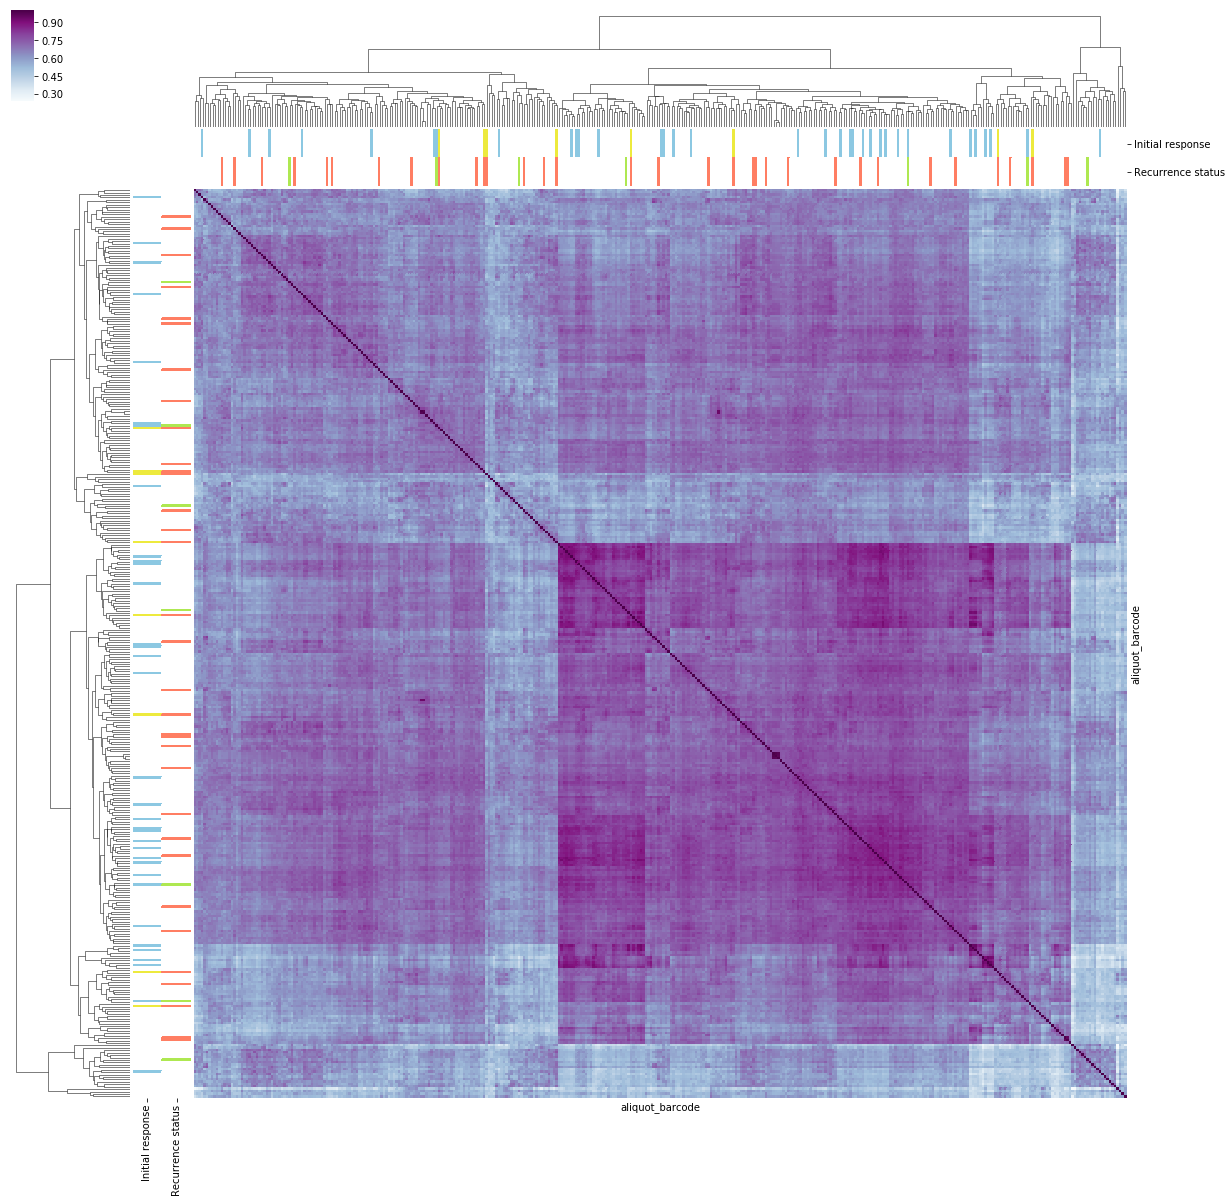

In [38]:
sns.clustermap(data=matrix.corr(), method='weighted', 
               row_colors = color_matrix, col_colors = color_matrix,
               cmap="BuPu", vmax=1, figsize=(20,20), 
               xticklabels=False, yticklabels=False)

# Normal tissues only

In [39]:
only_normal = hormone_meth_bigtable.loc[hormone_meth_bigtable['sample_type'] == 11]
matrix = only_normal.pivot(index='probe_id', columns='aliquot_barcode', values='beta_value')

print(matrix.shape)
matrix.head()

(1605, 42)


aliquot_barcode,TCGA-A7-A0CH-11A-32D-A10Q-05,TCGA-A7-A0D9-11A-53D-A10Q-05,TCGA-A7-A0DB-11A-33D-A093-05,TCGA-A7-A0DC-11A-41D-A10Q-05,TCGA-A7-A13F-11A-42D-A12R-05,TCGA-A7-A13G-11A-51D-A13T-05,TCGA-AC-A2FB-11A-13D-A17F-05,TCGA-AC-A2FF-11A-13D-A17F-05,TCGA-AC-A2FG-11A-22D-A17F-05,TCGA-BH-A0AY-11A-23D-A10Q-05,...,TCGA-E9-A1NA-11A-33D-A145-05,TCGA-E9-A1NE-11A-43D-A14N-05,TCGA-E9-A1NF-11A-73D-A14H-05,TCGA-E9-A1NG-11A-52D-A14N-05,TCGA-E9-A1R7-11A-42D-A14N-05,TCGA-E9-A1RB-11A-33D-A161-05,TCGA-E9-A1RC-11A-33D-A161-05,TCGA-E9-A1RD-11A-33D-A161-05,TCGA-E9-A1RF-11A-32D-A161-05,TCGA-E9-A1RI-11A-41D-A16A-05
probe_id,,,,,,,,,,,,,,,,,,,,,
cg00000321,0.26,0.21,0.25,0.26,0.26,0.28,0.27,0.30,0.29,0.23,...,0.29,0.20,0.23,0.24,0.20,0.28,0.36,0.28,0.39,0.36
cg00008036,0.17,0.07,0.09,0.10,0.11,0.09,0.19,0.12,0.15,0.13,...,0.16,0.08,0.12,0.10,0.11,0.22,0.20,0.12,0.27,0.10
cg00024494,0.72,0.50,0.59,0.83,0.70,0.61,0.67,0.75,0.70,0.78,...,0.62,0.72,0.62,0.55,0.56,0.73,0.66,0.64,0.68,0.48
cg00035316,0.21,0.11,0.13,0.31,0.21,0.19,0.33,0.21,0.45,0.23,...,0.26,0.16,0.20,0.18,0.18,0.10,0.15,0.17,0.09,0.30
cg00040588,0.60,0.43,0.46,0.53,0.41,0.39,0.48,0.37,0.39,0.57,...,0.48,0.43,0.40,0.38,0.35,0.53,0.61,0.40,0.61,0.42


In [40]:
color_matrix = pd.DataFrame()
df = only_normal.drop_duplicates(subset="aliquot_barcode")

c = dict(zip(df['initial_response'].unique(), ["#ffffff", "#8cc8e2", "#edea3d"]))
color_matrix['Initial response'] = df['initial_response'].map(c)

c = dict(zip(df['recurrence_status'].unique(), ["#ffffff", "#ff7e63", "#ffffff", "#aee851"]))
color_matrix['Recurrence status'] = df['recurrence_status'].map(c)

color_matrix.set_index(df['aliquot_barcode'], inplace=True)
color_matrix.head()

,Initial response,Recurrence status
aliquot_barcode,,
TCGA-A7-A13G-11A-51D-A13T-05,#ffffff,#ffffff
TCGA-E9-A1NA-11A-33D-A145-05,#ffffff,#ff7e63
TCGA-E9-A1RC-11A-33D-A161-05,#ffffff,#ff7e63
TCGA-E9-A1NF-11A-73D-A14H-05,#ffffff,#ffffff
TCGA-E2-A1IO-11A-21D-A145-05,#ffffff,#ff7e63


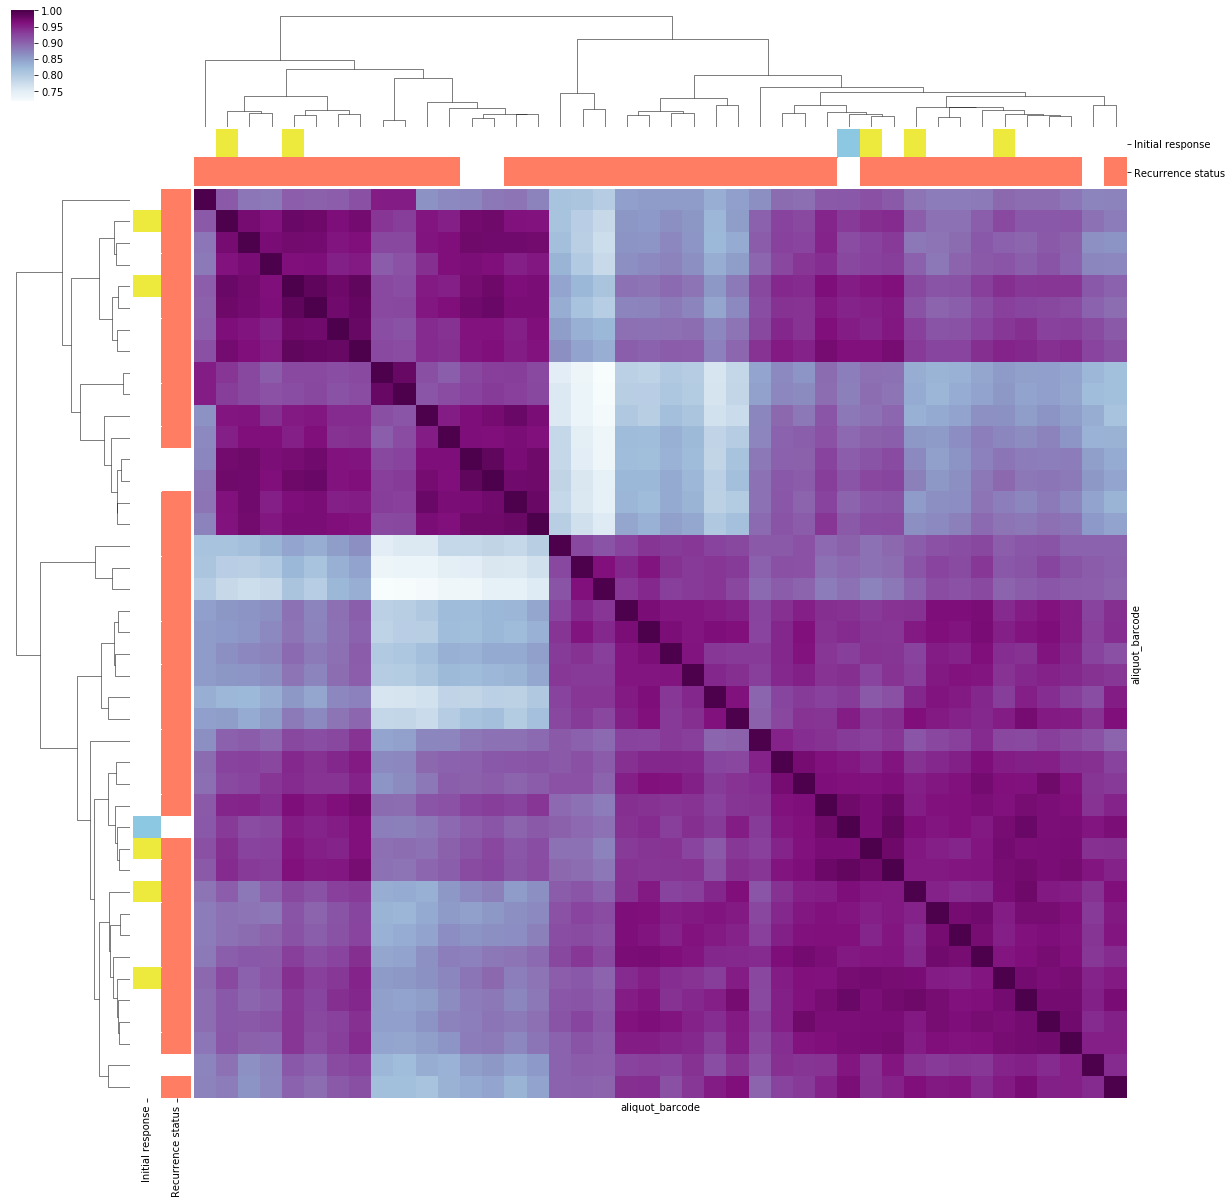

In [41]:
sns.clustermap(data=matrix.corr(), method='average', 
               row_colors = color_matrix, col_colors = color_matrix,
               cmap="BuPu", vmax=1, figsize=(20,20), 
               xticklabels=False, yticklabels=False)